In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt

name = "peregrine_boi-4"

p = os.path.abspath(f"../doctors/{name}/")

w_in = np.load(os.path.join(p, "w_in.npy"))
w = np.load(os.path.join(p, "w.npy"))
w_out = np.load(os.path.join(p, "w_out.npy"))
neurons = np.load(os.path.join(p, "neurons.npy")).T

print("W_in", "max", "mean", "sd")
print(np.max(np.abs(w_in)), np.mean(w_in), np.std(w_in))

print("W", "max", "mean", "sd")
print(np.max(np.abs(w)), np.mean(w), np.std(w))

print("W_out", "max", "mean", "sd")
print(np.max(np.abs(w_out)), np.mean(w_out), np.std(w_out))

print("W spectral radius")
print(np.max(np.abs(np.linalg.eigvals(w))))

W_in max mean sd
0.2664951017745444 -0.002252453630608908 0.08667061291506668
W max mean sd
0.3250360708076875 -0.0002897432783351756 0.09458301517889883
W_out max mean sd
2.8682319603245707 -0.0022381047291693845 0.7028748951301635
W spectral radius
0.9499999999999991


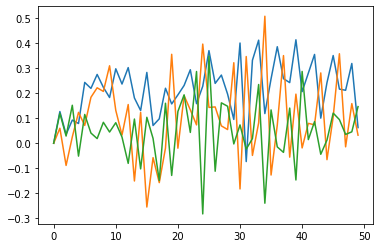

In [21]:
n = np.arange(neurons.shape[1])

indicies = n < 50

plt.plot(n[indicies], neurons[0][indicies])
#plt.plot(n[indicies], neurons[1][indicies])
plt.plot(n[indicies], neurons[2][indicies])
#plt.plot(n[indicies], neurons[3][indicies])
plt.plot(n[indicies], neurons[4][indicies])
#plt.plot(n[indicies], neurons[5][indicies])


NRMSE: 0.8923192986445576


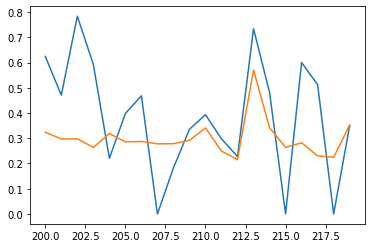

In [19]:
ys = np.load("../trash/ys.npy")
yhats = np.load("../trash/yhats.npy")

delta = np.mean((yhats - ys) * (yhats - ys), axis=0)
variances = np.var(ys, axis=0)
NMSE = delta / variances
NRMSE = np.sqrt(NMSE)
NRMSE = np.mean(NRMSE)

print(f"NRMSE: {NRMSE}")

y = ys.T
yhat = yhats.T
n = np.arange(ys.shape[0])

window = 20
begin = 200
indicies = (n >= begin) & (n < (begin + window))

plt.plot(n[indicies], y[0][indicies], label="y")
plt.plot(n[indicies], yhat[0][indicies], label="yhat")

In [26]:
import numpy as np


n = 5

_min = -1
_max = 1
mat = []
for i in range(n):
    row = []
    for z in range(n):
        if abs(z - i) <= 2:
            row.append(np.random.random() * (_max - _min) + _min)
        else:
            row.append(0)
    mat.append(row)

mat = np.array(mat)
mat

array([[ 0.30895718, -0.54979304, -0.84375176,  0.        ,  0.        ],
       [-0.56017922, -0.67310392,  0.43141763, -0.84602902,  0.        ],
       [-0.84499706, -0.83717716,  0.5355727 , -0.22475345,  0.94318291],
       [ 0.        , -0.93488629,  0.15599771, -0.1621522 , -0.27246862],
       [ 0.        ,  0.        , -0.17525313, -0.03975665, -0.95524118]])